In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

## Exercice 1:

Q1 : Pour l’image four.png fournie, de taille 100 × 100 pixels, considérons que rmin = 1, rmax = 100,
δr = 2. Combien de valeurs discrètes aura-t-on pour la coordonnée r des cercles ? Et si δr = 0.5 ?

In [3]:
print(len(np.arange(1,101,2)))
print(len(np.arange(1,101,0.5)))

50
200


Q2: 

In [4]:
print(len(np.arange(1,101,1)) *
      len(np.arange(1,101,1)) * 
      len(np.arange(5,(100*np.sqrt(2))+1,1)))

1380000


Q3:

- Cercle de rayon 1  pixel et de centre (1 , 1)
- Cercle de rayon 30 pixel et de centre (7 ,10)

Q4

Rmin = 1 et δr = 1, Cmin = 1 et δc = 1, RADmin = 5 et δrad = 1,   

=> acc[39][39][7]

## Exercice 2: Implementation du Detecteur

Q1:

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt 
def plot_image(cv_img,g=0,title=""):
    if cv_img is None:
        print("Error: Image not found or unable to read.")
    else:
        if (g==1):
            rgb_img = cv.cvtColor(cv_img,cv.COLOR_BGR2RGB)
            plt.imshow(rgb_img)
        else:
            plt.imshow(cv_img, cmap='gray')
        plt.title(title)
        plt.show()

(100, 100, 3)


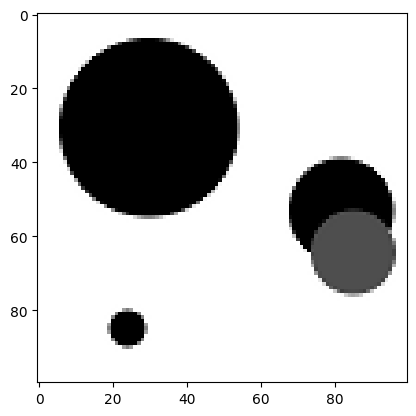

In [6]:
#trial  with four.png
images_dir = './images/'
four = cv.imread(f'{images_dir}/four.png')
print(np.shape(four))
plot_image(four)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..1020].


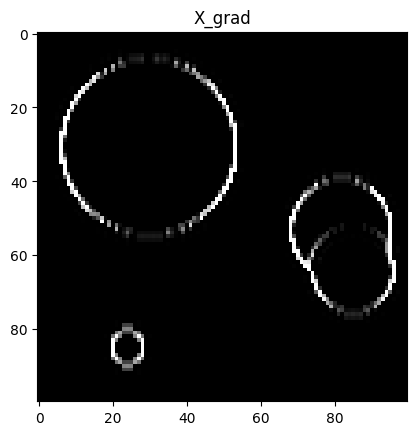

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..1020].


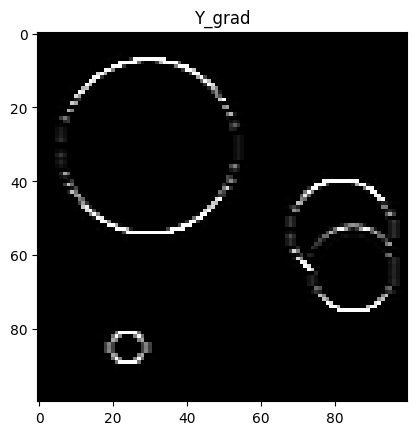

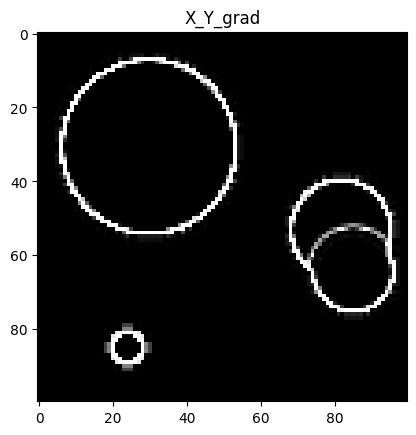

In [7]:
# Trial with Sobel
gray = cv.cvtColor(four,cv.COLOR_BGR2GRAY)
sobel_x = cv.Sobel(gray,ddepth=cv.CV_16U,dx=2,dy=0)
sobel_y = cv.Sobel(gray,ddepth=cv.CV_16U,dx=0,dy=2)
plot_image(sobel_x,g=1,title='X_grad')
plot_image(sobel_y,g=1,title='Y_grad')
sobel_x_y = sobel_x + sobel_y
sobel_x_y = np.clip(sobel_x_y,0,255)
plot_image(sobel_x_y,g=1,title='X_Y_grad')


In [8]:
# get the gradient in the x and y diections
def get_grad_x_y(img, order):
    
    sobel_x = cv.Sobel(img, ddepth=cv.CV_64F, dx=order, dy=0, ksize=3)
    sobel_y = cv.Sobel(img, ddepth=cv.CV_64F, dx=0, dy=order, ksize=3)
    
    # Computing gradient magnitude
    sobel_x_y = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalizing to 8-bit range and clip
    sobel_x_y = np.uint8(np.clip(sobel_x_y / sobel_x_y.max() * 255, 0, 255))
    sobel_x = np.uint8(np.clip(np.abs(sobel_x) / np.abs(sobel_x).max() * 255, 0, 255))
    sobel_y = np.uint8(np.clip(np.abs(sobel_y) / np.abs(sobel_y).max() * 255, 0, 255))
    
    return sobel_x_y, sobel_x, sobel_y

In [ ]:
import math


#calculate the difference between two points
def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return int(round(distance))

# get the accumulator
def get_accumulateur(grad_img,rmin,rmax,dr,cmin,cmax,dc,radmin,radmax,drad,int_thresh):
    img_dim_y,img_dim_x = np.shape(grad_img)

    rmax   = min(rmax,img_dim_y)                                                          # minimum of rmax and the rows of the image
    cmax   = min(cmax,img_dim_x)                                                          # minimum of cmax and the columnss of the image
    radmax = np.ceil(min(radmax,np.sqrt(img_dim_x**2 + img_dim_y**2))).astype(int)        # minimum of radmax and the diagonal

    max_grad = np.max(grad_img)
    contour_pixels = np.argwhere(grad_img > int_thresh * max_grad)

    # getting the dimensions of the accumulator
    acc_dim_r   = np.ceil((rmax-rmin+1)/dr).astype(int)                                 
    acc_dim_c   = np.ceil((cmax-cmin+1)/dc).astype(int)                                 
    acc_dim_rad = np.ceil((radmax-radmin+1)/drad).astype(int)

    acc = np.zeros((acc_dim_r,acc_dim_c,acc_dim_rad))

    for y,x in contour_pixels:
        for r_idx, r in enumerate(range(rmin, rmax, dr)):
            for c_idx, c in enumerate(range(cmin, cmax, dc)):
                rad = int(np.sqrt((x - c)**2 + (y - r)**2))
                if radmin <= rad < radmax:
                    rad_idx = (rad - radmin) // drad
                    acc[r_idx, c_idx, rad_idx] += 1
    return acc

# get the coordinates of the circles in the image
def get_cicrles(acc,rmin,dr,cmin,dc,radmin,radmax,drad,nb_circles=np.inf,acc_min_vote=26,circ_dist_r=3,circ_dist_c=3,circ_dist_rad=3):

    # number of cases to set to 0 surroungding the current max
    case_r   = np.ceil(circ_dist_r  / dr).astype(int)        
    case_c   = np.ceil(circ_dist_c  / dc).astype(int)
    case_rad = np.ceil(circ_dist_rad/ drad).astype(int)

    acc[acc < acc_min_vote] = 0
    acc /= (np.arange(radmin, radmin + acc.shape[2]* drad, drad) + 1)[None, None, :]
    circles = []
    visible_frac =[] # added to answer the 3rd exo
    i = 0
    while(i<nb_circles):
        ind = np.argpartition(acc.flatten(),-1)[-1]
        r_ind, c_ind, rad_ind = np.unravel_index(ind, acc.shape)        
        r = rmin + (r_ind * dr)
        c = cmin + (c_ind * dc)
        rad = radmin + (rad_ind * drad)
        if(acc[r_ind][c_ind][rad_ind] <=0):
            break
        circles.append([r, c, rad])
        visible_frac.appen(acc[r_ind][c_ind][rad_ind]) # added to answer the 3rd exo
        acc[
        max(r_ind - case_r, 0):min(r_ind + case_r + 1, acc.shape[0]),
        max(c_ind - case_c, 0):min(c_ind + case_c + 1, acc.shape[1]),
        max(rad_ind - case_rad, 0):min(rad_ind + case_rad + 1, acc.shape[2])
        ] = 0
        i+=1
    return (circles,visible_frac)


In [13]:
def draw_circles(img,c):
    for i in c:
        img = cv.circle(img, (i[1], i[0]),i[2],color=(0,0,255),thickness=1)
    return img

# function that does eveything from the beginning
def detect_circles(img, apply_gaussian=1, gaussian_dim=(5, 5), rmin=0, rmax=0, dr=1, 
                   cmin=0, cmax=0, dc=1, 
                   radmin=0, radmax=0, drad=1, 
                   int_thresh=0.5, acc_min_vote=10, nb_circles=np.inf,circ_dist_c=3,circ_dist_r=3,circ_dist_rad=2):
    orig_img = np.copy(img)
    #Gaussian blur
    if apply_gaussian:
        img = cv.GaussianBlur(img, gaussian_dim, sigmaX=2, sigmaY=2)
    
    
    
    img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    img_dim_y,img_dim_x = np.shape(img)
    rmax   = min(rmax,img_dim_y)                                                          # minimum of rmax and the rows of the image
    cmax   = min(cmax,img_dim_x)                                                          # minimum of cmax and the columnss of the image
    radmax = np.ceil(min(radmax,np.sqrt(img_dim_x**2 + img_dim_y**2))).astype(int)        # minimum of radmax and the diagonal


    # Compute gradient magnitude
    grad_img = get_grad_x_y(img, order=1)[0]  # Gradient computation after smoothing
    
    #grad_img = grad_img / grad_img.max()
    
    # Get accumulator
    acc = get_accumulateur(
        grad_img=grad_img,
        rmin=rmin,
        rmax=rmax,
        dr=dr,
        cmin=cmin,
        cmax=cmax,
        dc=dc,
        radmin=radmin,
        radmax=radmax,
        drad=drad,
        int_thresh=int_thresh
    )

    circles,visible_frac = get_cicrles(acc=acc,rmin=rmin,dr=dr,cmin=cmin,dc=dc,radmin=radmin,radmax=radmax,drad=drad,acc_min_vote=acc_min_vote,circ_dist_c=circ_dist_c,circ_dist_r=circ_dist_r,circ_dist_rad=circ_dist_rad,nb_circles=nb_circles)
    final_result = draw_circles(orig_img,circles)
    return circles,visible_frac,final_result


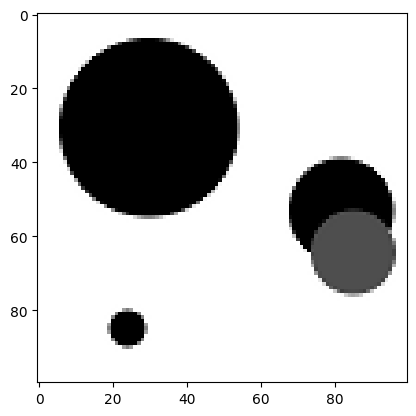

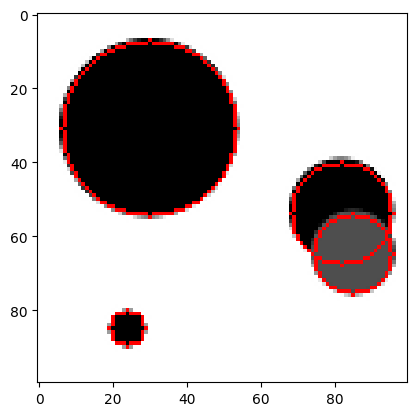

In [ ]:
four = 'images/four.png'
four = cv.imread(four)
plot_image(four,g=1)
c,visi,res = detect_circles(apply_gaussian=0, gaussian_dim=(3, 3), img=four, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=4)
plot_image(res,g=1)

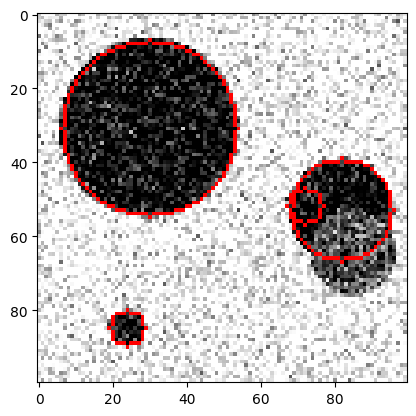

In [15]:
# Without Gaussian

fourn = 'images/fourn.png'
fourn = cv.imread(fourn)
c,visi,res = detect_circles(apply_gaussian=0, gaussian_dim=(3, 3), img=fourn, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=4)
plot_image(res,g=1)

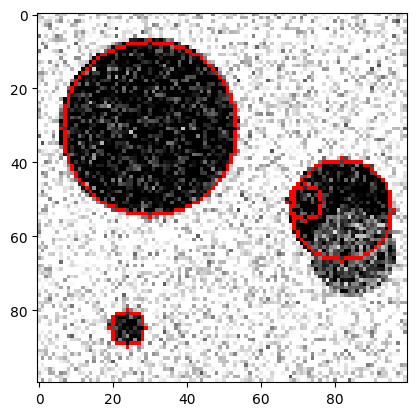

In [16]:
# With Gaussian Threshold 0.5
fourn = 'images/fourn.png'
fourn = cv.imread(fourn)
c,visi,res = detect_circles(apply_gaussian=True, gaussian_dim=(3, 3), img=fourn, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=4)
plot_image(res,g=1)

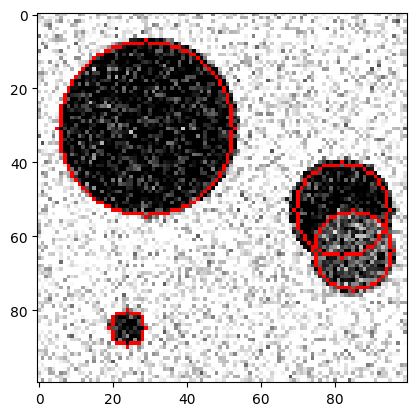

In [18]:
# With Gaussian Threshold 0.5
fourn = 'images/fourn.png'
fourn = cv.imread(fourn)
c,visi,res = detect_circles(apply_gaussian=True, gaussian_dim=(3, 3), img=fourn, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.3, acc_min_vote=10, nb_circles=4)
plot_image(res,g=1)

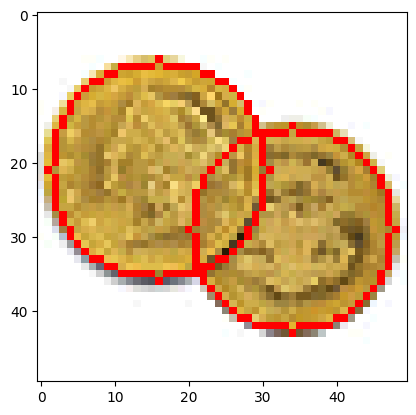

In [19]:
# Without Gaussian Threshold 0.5
coins = 'images/coins.png'
coins = cv.imread(coins)
c,visi,res = detect_circles(apply_gaussian=0, gaussian_dim=(3, 3), img=coins, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=2)
plot_image(res,g=1)

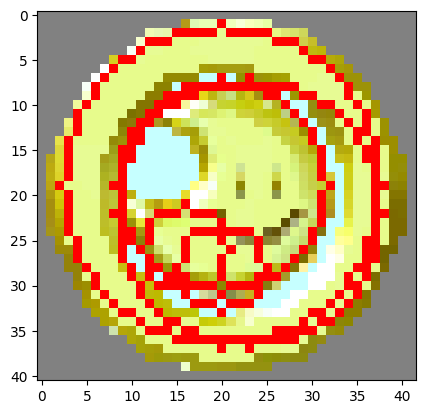

In [20]:
# Without Gaussian Threshold 0.5
MoonCoin = 'images/MoonCoin.png'
MoonCoin = cv.imread(MoonCoin)
c,visi,res = detect_circles(apply_gaussian=0, gaussian_dim=(3, 3), img=MoonCoin, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=5)
plot_image(res,g=1)

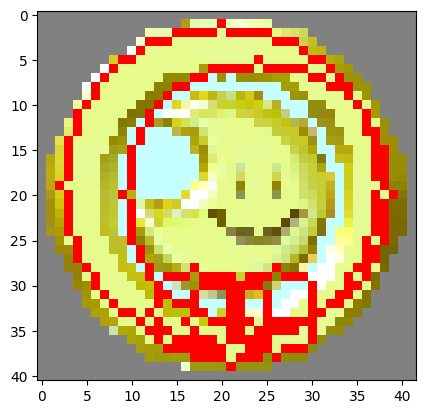

In [21]:
# With Gaussian Threshold 0.5
MoonCoin = 'images/MoonCoin.png'
MoonCoin = cv.imread(MoonCoin)
c,visi,res = detect_circles(apply_gaussian=True, gaussian_dim=(3, 3), img=MoonCoin, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=5)
plot_image(res,g=1)

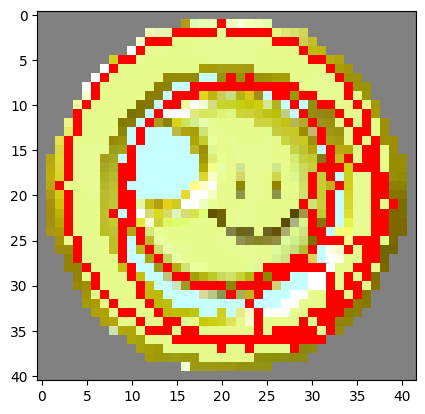

In [22]:
# Without Gaussian Threshold 0.5
MoonCoin = 'images/MoonCoin.png'
MoonCoin = cv.imread(MoonCoin)
c,visi,res = detect_circles(apply_gaussian=True, gaussian_dim=(3, 3), img=MoonCoin, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.7, acc_min_vote=10, nb_circles=5)
plot_image(res,g=1)

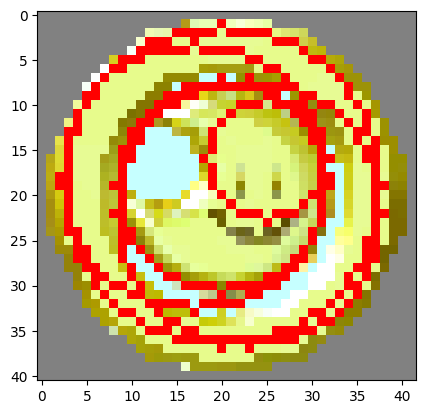

In [81]:
# Without Gaussian Threshold 0.5
MoonCoin = 'images/MoonCoin.png'
MoonCoin = cv.imread(MoonCoin)
c,visi,res = detect_circles(apply_gaussian=False, gaussian_dim=(1, 1), img=MoonCoin, 
                            rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=6, 
                            radmax=500, drad=1, int_thresh=0.5, acc_min_vote=5, nb_circles=5,
                            circ_dist_c=2,circ_dist_r=2,circ_dist_rad=2)
plot_image(res,g=1)

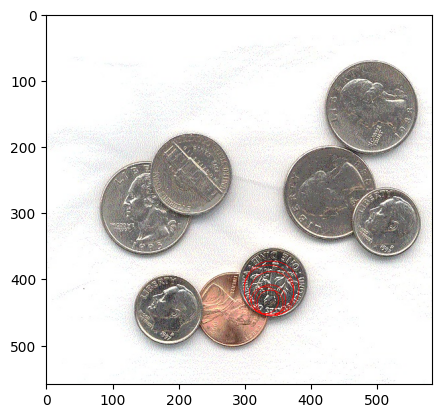

In [101]:
# Without Gaussian Threshold 0.5
coins2 = 'images/coins2.jpg'
coins2 = cv.imread(coins2)
c,visi,res = detect_circles(apply_gaussian=0, gaussian_dim=(3, 3), img=coins2, rmin=0, rmax=1000, dr=2, cmin=0, cmax=1000, dc=2, radmin=20, radmax=500, drad=1, int_thresh=0.7, acc_min_vote=10, nb_circles=6)
plot_image(res,g=1)

(559, 584, 3)


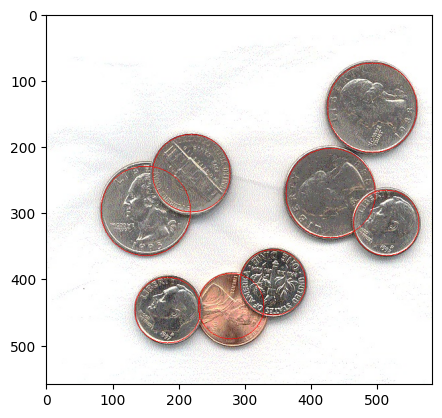

In [ ]:
# Without Gaussian Threshold 0.5
coins2 = 'images/coins2.jpg'
coins2 = cv.imread(coins2)
print(np.shape(coins2))
c,visi,res = detect_circles(apply_gaussian=True, gaussian_dim=(9, 9), 
                       img=coins2, rmin=0, rmax=1000, dr=3, cmin=0, 
                       cmax=1000, dc=3, radmin=50, radmax=250, drad=3, 
                       int_thresh=0.5, acc_min_vote=8, nb_circles=8,
                       circ_dist_r=40,circ_dist_c=40,circ_dist_rad=30)
plot_image(res,g=1)

## **EX3**

#### Question 1 : 

##### **Calculs de complexité temporelle:** 

##### 1) L’image contient N×N pixels. Chaque pixel est traité, ce qui donne une complexité de 𝑁<sup>2</sup>.

##### 2) 
##### * On parcourt les rayons compris entre radmin et radmax, où 0 <= radmin <= radmax <= N*N pixels.

##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;OU

##### * On parcourt les pixels de contour et on calcle le rayon correspondant (notre approche dans `get_accumulateur` ). Les nombre de pixels de contour est majoré par le nombre
#####  &nbsp;&nbsp;&nbsp; totale des pixels dans l'image N*N.

##### => Si la complexité temporelle est de N<sup>4</sup> pour une image de 100px. La complexité pour une image de 600 px est de 6<sup>4</sup>*N<sup>4</sup> = 1296*N<sup>4</sup>. La complexité d'une image 6X plus grande  qu'une image de 100 pixels est plus de 1000 X que celle d'origine.

##### Dans la suite on va mesurer le temps d'exécution de la fonction `detect_circles` pour chaque image en utilisant les configurations ayant donné les meilleurs résultats.

execution time for four : 14.694285438


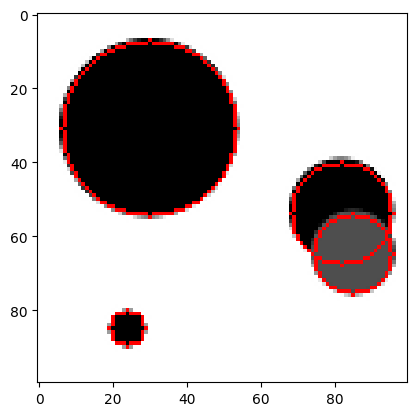

In [ ]:
images_dir = './images/'
four = cv.imread(f'{images_dir}/four.png')

four_e1 = cv.getTickCount()

_, __, result = detect_circles(apply_gaussian=0, gaussian_dim=(3, 3), img=four, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=4)

four_e2 = cv.getTickCount()
exec_time = (four_e2 - four_e1)/ cv.getTickFrequency()

print(f'execution time for four : {exec_time}')

plot_image(result,g=1)

execution time for fourn : 11.935801796


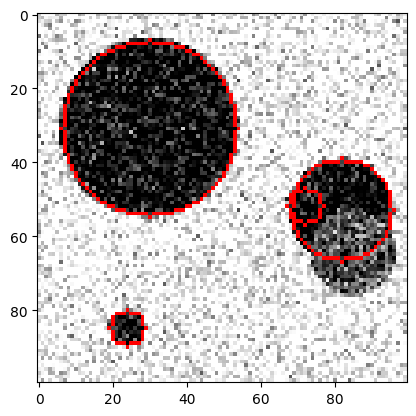

In [100]:
images_dir = './images/'
fourn = cv.imread(f'{images_dir}/fourn.png')

fourn_e1 = cv.getTickCount()
_,__, result = detect_circles(apply_gaussian=0, gaussian_dim=(3, 3), img=fourn, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=4)



fourn_e2 = cv.getTickCount()
fourn_time = (fourn_e2 - fourn_e1)/ cv.getTickFrequency()
print(f'execution time for fourn : {fourn_time}')
plot_image(result,g=1)


execution time for fourn : 1.329518478


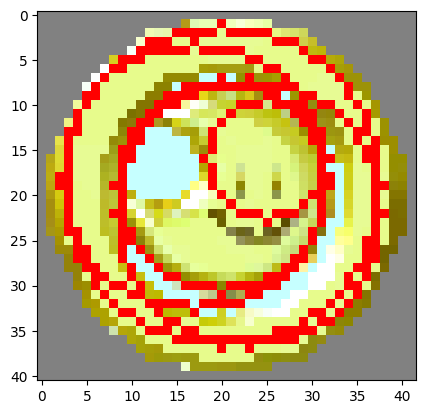

In [93]:
images_dir = './images/'
MoonCoin = cv.imread(f'{images_dir}/MoonCoin.png')

MoonCoin_e1 = cv.getTickCount()

_,__, result = detect_circles(apply_gaussian=False, gaussian_dim=(1, 1), img=MoonCoin, 
                            rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=6, 
                            radmax=500, drad=1, int_thresh=0.5, acc_min_vote=5, nb_circles=5,
                            circ_dist_c=2,circ_dist_r=2,circ_dist_rad=2)

MoonCoin_e2 = cv.getTickCount()

MoonCoin_time = (MoonCoin_e2 - MoonCoin_e1)/ cv.getTickFrequency()

print(f'execution time for fourn : {MoonCoin_time}')
plot_image(result,g=1)

execution time for fourn : 1.370683981


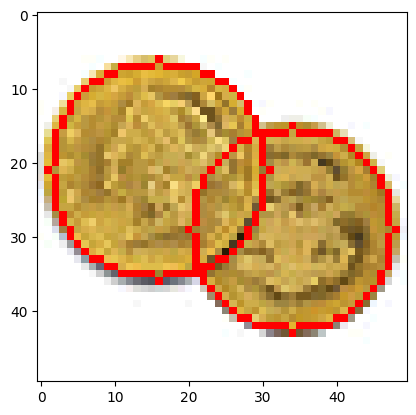

In [98]:
images_dir = './images/'
coins = cv.imread(f'{images_dir}/coins.png')

coins_e1 = cv.getTickCount()

_,__, result = detect_circles(apply_gaussian=0, gaussian_dim=(3, 3), img=coins, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=2)

coins_e2 = cv.getTickCount()
coins_time = (coins_e2 - coins_e1)/ cv.getTickFrequency()
print(f'execution time for fourn : {coins_time}')
plot_image(result,g=1)


execution time for fourn : 454.240544082


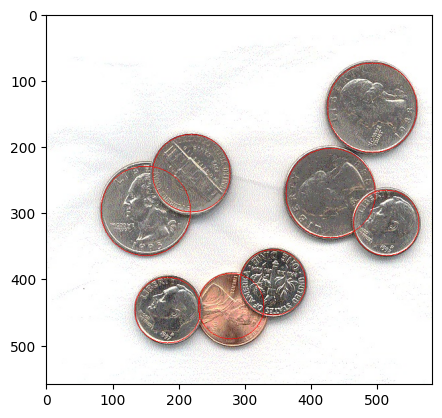

In [99]:
images_dir = './images/'
coins2 = cv.imread(f'{images_dir}/coins2.jpg')

coins2_e1 = cv.getTickCount()

_,__, result = detect_circles(apply_gaussian=True, gaussian_dim=(9, 9), 
                       img=coins2, rmin=0, rmax=1000, dr=3, cmin=0, 
                       cmax=1000, dc=3, radmin=50, radmax=250, drad=3, 
                       int_thresh=0.5, acc_min_vote=8, nb_circles=8,
                       circ_dist_r=40,circ_dist_c=40,circ_dist_rad=30)

coins2_e2 = cv.getTickCount()
coins2_time = (coins2_e2 - coins2_e1)/ cv.getTickFrequency()
print(f'execution time for fourn : {coins2_time}')
plot_image(result,g=1)


### Implementation avec la methode "direction du gradient"

In [105]:
def get_grad_x_y_ex3(img, order):
    sobel_x = cv.Sobel(img, ddepth=cv.CV_64F, dx=order, dy=0, ksize=3)
    sobel_y = cv.Sobel(img, ddepth=cv.CV_64F, dx=0, dy=order, ksize=3)
    
    # Computing gradient magnitude
    sobel_x_y = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Computing gradient direction (in radians)
    grad_dir = np.arctan2(sobel_y, sobel_x)  # Use unnormalized gradients for accurate angles

    return sobel_x_y, sobel_x, sobel_y, grad_dir


def get_accumulateur_ex3(grad_img, rmin, rmax, dr, cmin, cmax, 
                         dc, radmin, radmax, drad, int_thresh, 
                         grad_dir, beta,angle_step_size=1):
    
    img_dim_y, img_dim_x = grad_img.shape
    max_grad = np.max(grad_img)
    contour_pixels = np.argwhere(grad_img > int_thresh * max_grad)

    # Initialize the accumulator
    acc_dim_r = np.ceil((rmax - rmin + 1) / dr).astype(int)
    acc_dim_c = np.ceil((cmax - cmin + 1) / dc).astype(int)
    acc_dim_rad = np.ceil((radmax - radmin + 1) / drad).astype(int)
    acc = np.zeros((acc_dim_r, acc_dim_c, acc_dim_rad))

    for y, x in contour_pixels:
        grad_angle = grad_dir[y, x] + np.pi

        # Compute angular bounds
        angle_min = grad_angle - beta
        angle_max = grad_angle + beta

        # Iterate over radii
        for r in range(radmin, radmax, drad):
            for angle in np.arange(angle_min, angle_max, angle_step_size):  # Adjust step_size
                cos_a = np.cos(angle)
                sin_a = np.sin(angle)
                cx = int(x + r * cos_a)
                cy = int(y + r * sin_a)
                # Ensure (cx, cy) is within bounds
                if cmin <= cx < cmax and rmin <= cy < rmax:
                    r_idx = (cy - rmin) // dr
                    c_idx = (cx - cmin) // dc
                    rad_idx = (r - radmin) // drad

                    # Update accumulator
                    acc[r_idx, c_idx, rad_idx] += 1

    return acc


# function that does eveything from the beginning
def detect_circles_ex3(img, beta, angle_step_size=1, apply_gaussian=1, gaussian_dim=(5, 5), rmin=0, rmax=0, dr=1, 
                   cmin=0, cmax=0, dc=1,radmin=0, radmax=0, drad=1, 
                   int_thresh=0.5, acc_min_vote=10, nb_circles=np.inf,circ_dist_c=3,
                   circ_dist_r=3,circ_dist_rad=2):
    
    orig_img = np.copy(img)
    #Gaussian blur
    if apply_gaussian:
        img = cv.GaussianBlur(img, gaussian_dim, sigmaX=2, sigmaY=2)
    
    
    
    img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    img_dim_y,img_dim_x = np.shape(img)
    rmax   = min(rmax,img_dim_y)                                                          # minimum of rmax and the rows of the image
    cmax   = min(cmax,img_dim_x)                                                          # minimum of cmax and the columnss of the image
    radmax = np.ceil(min(radmax,np.sqrt(img_dim_x**2 + img_dim_y**2))).astype(int)        # minimum of radmax and the diagonal


    # Compute gradient magnitude
    grad_img, _, __, grad_dir = get_grad_x_y_ex3(img, order=1)  # Gradient computation after smoothing
    
    #grad_img = grad_img / grad_img.max()
    
    # Get accumulator
    acc = get_accumulateur_ex3(
        grad_img=grad_img,
        rmin=rmin,
        rmax=rmax,
        dr=dr,
        cmin=cmin,
        cmax=cmax,
        dc=dc,
        radmin=radmin,
        radmax=radmax,
        drad=drad,
        int_thresh=int_thresh,
        grad_dir=grad_dir,
        beta=beta,
        angle_step_size=angle_step_size
    )

    circles,visible_frac = get_cicrles(acc=acc,rmin=rmin,dr=dr,cmin=cmin,dc=dc,radmin=radmin,
                                       radmax=radmax,drad=drad,acc_min_vote=acc_min_vote,
                                       circ_dist_c=circ_dist_c,circ_dist_r=circ_dist_r,
                                       circ_dist_rad=circ_dist_rad,nb_circles=nb_circles)
    
    final_result = draw_circles(orig_img,circles)
    return circles,visible_frac,final_result





execution time for four : 2.868503354


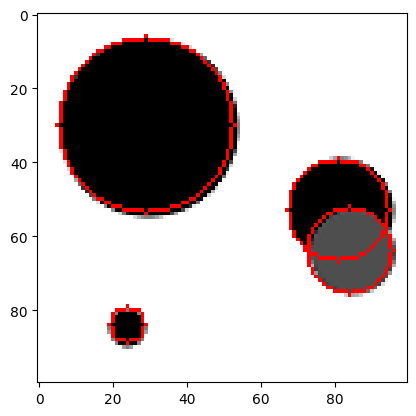

In [114]:

images_dir = './images/'
four = cv.imread(f'{images_dir}/four.png')

four_e1 = cv.getTickCount()

c,visi,res = detect_circles_ex3(apply_gaussian=False, beta=0.08,angle_step_size=0.018, gaussian_dim=(3, 3), img=four, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=4)

four_e2 = cv.getTickCount()

exec_time = (four_e2 - four_e1)/ cv.getTickFrequency()

print(f'execution time for four : {exec_time}')

plot_image(res,g=1)


execution time for four : 7.919301512


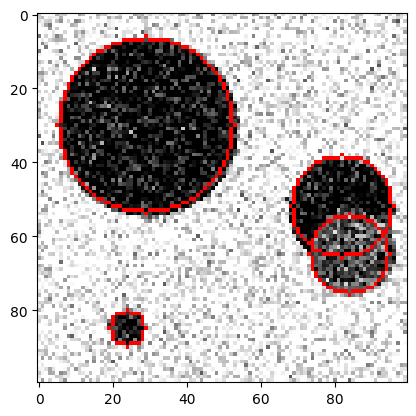

In [117]:
fourn = 'images/fourn.png'
fourn = cv.imread(fourn)

fourn_e1 = cv.getTickCount()

c,visi,res = detect_circles_ex3(apply_gaussian=True, beta=0.08, angle_step_size=0.018, gaussian_dim=(5, 5), img=fourn, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.3, acc_min_vote=10, nb_circles=4)

fourn_e2 = cv.getTickCount()

exec_time = (fourn_e2 - fourn_e1)/ cv.getTickFrequency()

print(f'execution time for four : {exec_time}')

plot_image(res,g=1)



execution time for four : 0.575615412


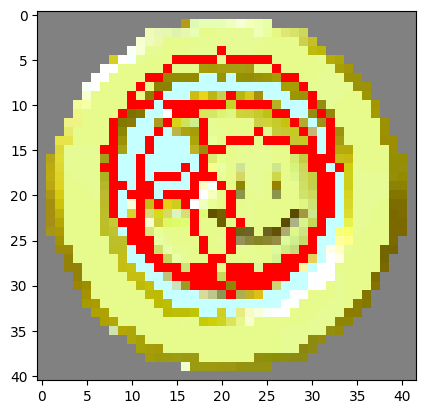

In [122]:
MoonCoin = 'images/MoonCoin.png'
MoonCoin = cv.imread(MoonCoin)

MoonCoin_e1 = cv.getTickCount()

c,visi,res = detect_circles_ex3(apply_gaussian=False, beta=0.08, angle_step_size=0.018, gaussian_dim=(5, 5), img=MoonCoin, 
                            rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=6, 
                            radmax=500, drad=1, int_thresh=0.5, acc_min_vote=5, nb_circles=5,
                            circ_dist_c=2,circ_dist_r=2,circ_dist_rad=2)
MoonCoin_e2 = cv.getTickCount()

exec_time = (MoonCoin_e2 - MoonCoin_e1)/ cv.getTickFrequency()

print(f'execution time for four : {exec_time}')

plot_image(res,g=1)

execution time for four : 0.514477508


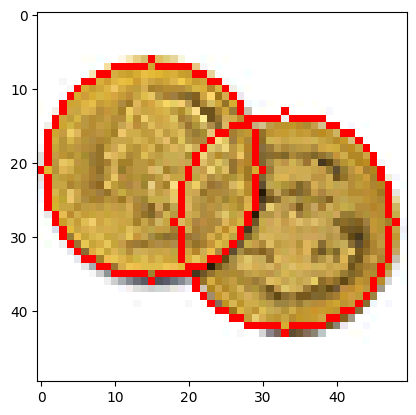

In [118]:
# Without Gaussian Threshold 0.5
coins = 'images/coins.png'
coins = cv.imread(coins)

coins_e1 = cv.getTickCount()


c,visi,res = detect_circles_ex3(apply_gaussian=0, beta=0.08, angle_step_size=0.018,gaussian_dim=(3, 3), img=coins, rmin=0, rmax=200, dr=1, cmin=0, cmax=200, dc=1, radmin=5, radmax=500, drad=1, int_thresh=0.5, acc_min_vote=10, nb_circles=2)

coins_e2 = cv.getTickCount()

exec_time = (coins_e2 - coins_e1)/ cv.getTickFrequency()

print(f'execution time for four : {exec_time}')

plot_image(res,g=1)


(559, 584, 3)
execution time for four : 75.116984847


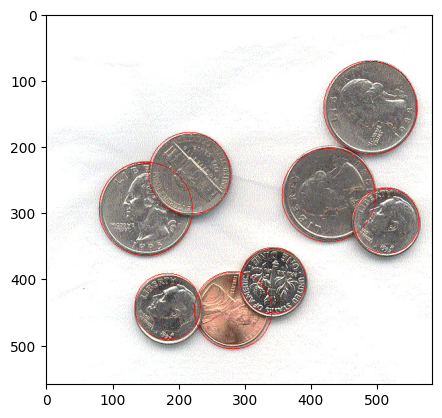

In [119]:
# Without Gaussian Threshold 0.5
coins2 = 'images/coins2.jpg'
coins2 = cv.imread(coins2)
print(np.shape(coins2))

coins2_e1 = cv.getTickCount()

c,visi,res = detect_circles_ex3(apply_gaussian=True, beta=0.08, angle_step_size=0.018,
                            gaussian_dim=(9, 9), img=coins2, rmin=0, rmax=1000, dr=3, cmin=0, 
                            cmax=1000, dc=3, radmin=50, radmax=250, drad=3, 
                            int_thresh=0.5, acc_min_vote=8, nb_circles=8,
                            circ_dist_r=40,circ_dist_c=40,circ_dist_rad=30)
coins_e2 = cv.getTickCount()

exec_time = (coins_e2 - coins_e1)/ cv.getTickFrequency()

print(f'execution time for four : {exec_time}')

plot_image(res,g=1)
